In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
# https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py

/root/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [26]:
# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 3
# number of elements ahead that are used to make the prediction
lahead = 1

In [3]:
def gen_cosine_amp(amp=100, period=1000, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos

In [15]:
print('Generating Data')
cos = gen_cosine_amp()
print('Input shape:', cos.shape)
print (cos[1:5])

Generating Data
Input shape: (50000, 1, 1)
[[[ 99.98802678]]

 [[ 99.972108  ]]

 [[ 99.95224507]]

 [[ 99.92843956]]]


In [16]:
expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

print('Output shape')
print(expected_output.shape)
print (expected_output[1:5])

Output shape
(50000, 1)
[[ 99.972108  ]
 [ 99.95224507]
 [ 99.92843956]
 [ 99.9006932 ]]


In [17]:
print('Creating Model')
model = Sequential()
model.add(LSTM(20,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=True,
               stateful=True))
model.add(LSTM(20,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

Creating Model


In [27]:
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(cos,
              expected_output,
              batch_size=batch_size,
              verbose=1,
              nb_epoch=1,
              shuffle=False)
    model.reset_states()

Training
Epoch 0 / 3
Epoch 1/1
50000/50000 [==============================] - 28s - loss: 79.4604    
Epoch 1 / 3
Epoch 1/1
50000/50000 [==============================] - 28s - loss: 63.2035    
Epoch 2 / 3
Epoch 1/1
50000/50000 [==============================] - 28s - loss: 51.1864    


In [28]:
print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)
print (expected_output[1:5])
print (predicted_output[1:5])
print (predicted_output.shape)

Predicting
[[ 99.972108  ]
 [ 99.95224507]
 [ 99.92843956]
 [ 99.9006932 ]]
[[ 27.37412834]
 [ 27.37412643]
 [ 27.37412834]
 [ 27.37413025]]
(50000, 1)


In [29]:
print (expected_output[4001:4005])
print (predicted_output[4001:4005])
print (expected_output[40001:40005])
print (predicted_output[40001:40005])

[[ 67.01330804]
 [ 66.99999351]
 [ 66.9840362 ]
 [ 66.96543727]]
[[ 43.07381439]
 [ 43.04713821]
 [ 43.01917267]
 [ 42.99278259]]
[[ 1.83105303]
 [ 1.83068923]
 [ 1.83025321]
 [ 1.82974502]]
[[ 1.60969877]
 [ 1.61093676]
 [ 1.61212707]
 [ 1.6132586 ]]


Plotting Results


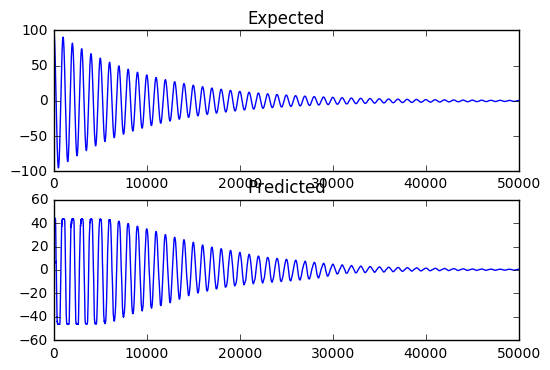

In [30]:
print('Plotting Results')
plt.subplot(2, 1, 1)
plt.plot(expected_output)
plt.title('Expected')
plt.subplot(2, 1, 2)
plt.plot(predicted_output)
plt.title('Predicted')
plt.show()

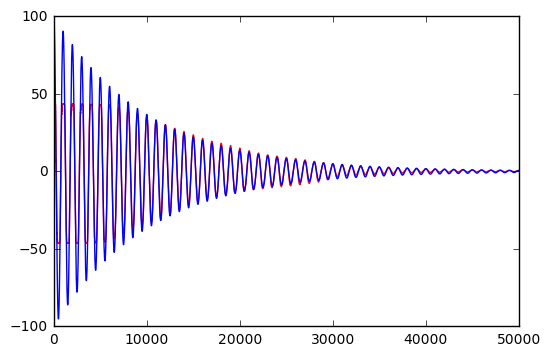

In [31]:
plt.plot(predicted_output, 'r-', expected_output, 'b-')
plt.show()